# (E17) 다음에 볼 영화 예측하기
- 일시: 2021.03.11
*****

# Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해보자.
*****

# Step 1. 데이터 준비하기
## 데이터 로드

In [67]:
# 라이브러리 준비.
import datetime as dt
from datetime import date
import time 
from time import strftime
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [96]:
# 데이터 설명 읽기.
f = open(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m/README', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

In [97]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- **UserID**    
- **Rating: 제외할 것인가? 낮은 Rating를 가진 데이터는 어떻게 처리할 것인가?**    
- **Time: UTC time 포함, 1970년 1월 1일부터 경과된 초단위 시간이 기재.**

In [98]:
# 추천시스템 구축 시 가장 먼저 봐야하는 것은 유저수와 아이템(영화)수.
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

# Step 2. 데이터 전처리
**위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행.**    
**특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의.**

## Session Length
- **UserID를 기준으로 사용자의 행동을 모아서 분류할 수 있음.    
 --> 어떤 유저가 영화를 몇편이나 감상했는지 알 수 있음.**

In [99]:
# 유저가 감상한 영화의 갯수
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [100]:
# 주요 통계치 살펴보기.
print("유저의 영화 감상 갯수의 중앙값: ", user_length.median())
print("유저의 영화 감상 갯수의 평균값: ", user_length.mean())
print("유저의 영화 감상 갯수 중 가장 작은 값: ", user_length.min())
print("유저의 영화 감상 갯수 중 가장 큰 값: ", user_length.max())
# 사분위수는 자료 크기 순서에 따른 위치값.
# 최댓값 바로 밑의 값을 나타냄.
print("유저의 영화 감상 갯수의 사분위수: ", user_length.quantile(0.999))

유저의 영화 감상 갯수의 중앙값:  96.0
유저의 영화 감상 갯수의 평균값:  165.5975165562914
유저의 영화 감상 갯수 중 가장 작은 값:  20
유저의 영화 감상 갯수 중 가장 큰 값:  2314
유저의 영화 감상 갯수의 사분위수:  1343.181000000005


- **99.9% 유저는 1343개 이하의 영화를 봄.**    
- **근데 2314개의 영화를 본 유저가 있다니 이상함으로 확인해보자.**

In [101]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


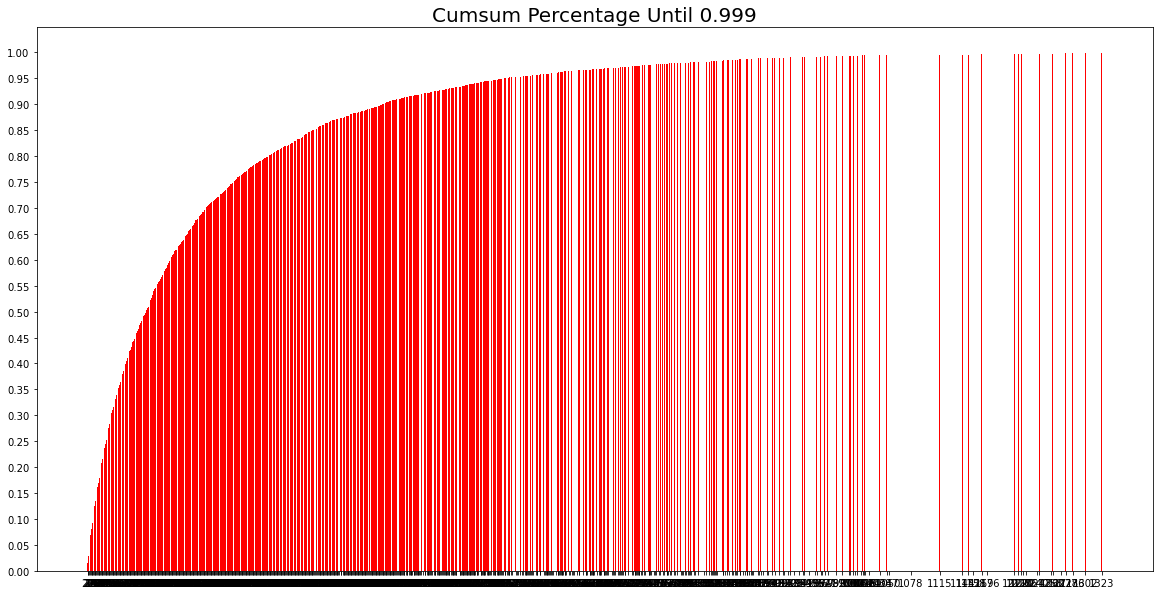

In [102]:
import matplotlib.pyplot as plt

length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## Session Time

In [103]:
# 1970년 1월 1일부터 1초로 표현되어 있으므로 계산이 편한 시간으로 바꿔줌. 

time_str = []

for i in data['Time']:
    time_conv = dt.datetime.fromtimestamp(i)
    time_str.append(time_conv)
    
data['Time'] = time_str

In [104]:
# 데이터 시간 정보 확인하기.
oldest, latest = data['Time'].min(), data['Time'].max()

print(oldest) 
print(latest)
print(type(latest))

2000-04-26 08:05:32
2003-03-01 02:49:50
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [105]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구하기.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모으기. 
data

,UserId,ItemId,Rating,Time
28225,195,2808,3,2003-02-03 06:08:38
27759,195,1254,4,2003-02-07 02:23:42
27921,195,1456,2,2003-02-08 09:07:32
28443,195,468,3,2003-02-12 02:42:36
28255,195,2748,1,2003-02-12 03:23:28
...,...,...,...,...
984731,5950,3948,4,2003-02-28 03:13:57
984682,5950,3578,4,2003-02-28 03:14:30
984475,5950,3793,3,2003-02-28 03:15:10
984660,5950,3555,2,2003-02-28 03:15:37


## Data Cleansing

In [106]:
# short_session을 제거 후, unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있음.
# 영화를 하나라도 보면 다음 클릭을 예측할 수 있다고 간주하겠음.
# 이를 위해 반복문을 통해 지속적으로 제거.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [107]:
data = cleanse_recursive(data, shortest=20, least_click=1)
data.head()

,UserId,ItemId,Rating,Time
52892,349,2060,2,2003-01-31 08:33:12
53002,349,145,3,2003-01-31 08:33:12
53058,349,2699,3,2003-01-31 08:33:12
53090,349,65,2,2003-01-31 08:33:45
53009,349,223,3,2003-01-31 08:34:42


# Step 2. 미니 배치의 구성
## Dataset Split

In [113]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [114]:
# train, test, val dataset split
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [115]:
# data에 대한 정보를 살펴보기.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [116]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 881
	 Sessions: 10
	 Items: 678
	 First Time : 2003-01-31 00:50:01
	 Last Time : 2003-02-26 04:06:16

* valid Set Stats Info
	 Events: 45
	 Sessions: 2
	 Items: 45
	 First Time : 2003-02-07 03:24:37
	 Last Time : 2003-02-27 01:06:24

* test Set Stats Info
	 Events: 81
	 Sessions: 2
	 Items: 81
	 First Time : 2003-02-08 00:00:50
	 Last Time : 2003-03-01 02:49:50



In [117]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [118]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Mini Batch

In [119]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [120]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
52892,349,2060,2,2003-01-31 08:33:12,0
53002,349,145,3,2003-01-31 08:33:12,1
53058,349,2699,3,2003-01-31 08:33:12,2
53090,349,65,2,2003-01-31 08:33:45,3
53009,349,223,3,2003-01-31 08:34:42,4
52996,349,135,3,2003-01-31 08:35:14,5
52934,349,788,3,2003-01-31 08:37:06,6
53033,349,185,3,2003-01-31 08:37:06,7
52906,349,1347,2,2003-01-31 08:37:10,8
53040,349,196,3,2003-01-31 08:38:15,9


In [121]:
tr_dataset.click_offsets

array([  0,  21, 241, 320, 364, 529, 720, 781, 809, 833, 881], dtype=int32)

In [122]:
tr_dataset.session_idx

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [123]:
# 데이터 로더 만들기. 
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [124]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
52892,349,2060,2,2003-01-31 08:33:12,0
53002,349,145,3,2003-01-31 08:33:12,1
53058,349,2699,3,2003-01-31 08:33:12,2
53090,349,65,2,2003-01-31 08:33:45,3
53009,349,223,3,2003-01-31 08:34:42,4
52996,349,135,3,2003-01-31 08:35:14,5
52934,349,788,3,2003-01-31 08:37:06,6
53033,349,185,3,2003-01-31 08:37:06,7
52906,349,1347,2,2003-01-31 08:37:10,8
53040,349,196,3,2003-01-31 08:38:15,9


In [125]:
iter_ex = iter(tr_data_loader)

In [143]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  1  22 239  63]
Label Item Idx are :       [  2  23 240 304]
Previous Masked Input Idx are []


# Step 3. 모델 구성

In [144]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [145]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [146]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [147]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=1, k=20)

In [148]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(2048, 1, 678)]          0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  109500    
_________________________________________________________________
dropout_2 (Dropout)          (2048, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (2048, 678)               34578     
Total params: 144,078
Trainable params: 144,078
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습

In [149]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [150]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train: 0it [00:00, ?it/s]


IndexError: index 10 is out of bounds for axis 0 with size 10

# Step 5. 모델 테스트

In [151]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 0it [00:00, ?it/s]


IndexError: index 2 is out of bounds for axis 0 with size 2

****

# 루브릭 평가

|**평가문항**|**상세기준**|
|:-------|:------|
|**1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.**|**데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.**|
|**2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.**|**적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.**|
|**3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.**|**3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.**|


**이번 노드는 한번 보고 제출하는 데에 의의를 둬야겠다. 추천시스템은 정말 나와 맞지 않는 것 같다. 제출부터 하고 나중에 어떤 부분에서 오류가 생긴 것인지 살펴봐야겠다.**

# 회고

**노드를 한번 밀리니까 끝도 없다. 주말에 해야한다고 생각만 하고 하지 않아서 그런 것 같다. 이번에 그 1970년 1월 1일부터 1초로 표현한 타임스탬프 때문에 시간을 다 잡아먹어버렸다. 아니 도대체 왜 그런 시간 표현법을 만든건지 원... 이해가 될질 않는다. 화난다...!**